In [ ]:
!pip install pettingzoo

import numpy as np
import gym
from gym import spaces
from gym.spaces import Discrete, Tuple, Dict
from collections import namedtuple

from pettingzoo import AECEnv

!pip install -q tf
from tensorflow import summary
%load_ext tensorboard


from google.colab import drive
drive.mount('/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 816 kB 6.2 MB/s 
     |████████████████████████████████| 836 kB 37.6 MB/s 
Mounted at /gdrive


In [ ]:
class GameOfSkullEnv(AECEnv):
  metadata = {
        "render_modes": ["human"],
        "name": "skull",
        "is_parallelizable": False,
        "render_fps": 1,
    }

  def __init__(self, agent_selection=None, observation_space=None):
    super().__init__()
    self._init(agent_selection, observation_space)

  def _init(self, agent_selection=None, observation_space=None):
    self.agents = ['agent0', 'agent1']
    self.num_roses = [3, 3]
    self.num_skulls = [1, 1]
    self.history_cards = 0
    self.action = None
    self.skulls = {"skull0": 1, "skull1": 1}
    self.passed = -1
    self.played = 0
    

    if agent_selection == None and observation_space==None:
      self.agent_selection = 0
      self.phase = 0
      self.current_bet = 0
      self.cards_to_flip = {}
      

      self.observation_space = {
      'agent0': [0, 0, 0, 0],
      'agent1': [0, 0, 0, 0],
      'current_bet': 0,
      'cards_to_flip': 0,
      'skull': 1,
      'phase': 0
      }
      
    else:
      self.observation_space = observation_space
      self.agent_selection = agent_selection
      self.cards_to_flip = list(self.observation_space['agent'+str(self._next_turn())]) + list(self.observation_space['agent' + str(self.agent_selection)])
      self.phase = self.observation_space['phase']
      self.current_bet = self.observation_space['current_bet']
      self.skulls['skull'+str(self.agent_selection)] = self.observation_space['skull']
    
    self.rewards = [0,0]
    self.dones = {'agent0': False, 'agent1': False, "__all__": False}
    self.action_spaces = Tuple([Discrete(4), Discrete(8)])
    
    self.observation = namedtuple("observation_space", "self0 self1 self2 self3 opp0 opp1 opp2 opp3 current_bet cards_to_flip skull phase")
    
  
  def reset(self, agent_selection=None, observation_space=None):
    self._init(agent_selection, observation_space)
    return self.get_observation_space()

  def _int_to_name(self, ind):
    return self.agents[ind]

  def _name_to_int(self, name):
    return self.agents.index(name)

  def _next_turn(self):
    return abs(self.agent_selection-1)


  def _accumulate_rewards(self):
    """
    Adds .rewards dictionary to ._cumulative_rewards dictionary. Typically
    called near the end of a step() method
    """
    self._cumulative_rewards["agent0"] = self._cumulative_rewards["agent0"] + self.rewards[0]
    self._cumulative_rewards["agent1"] = self._cumulative_rewards["agent1"] + self.rewards[1]

  def step(self, action):
    info = {}
    agent = 'agent' + str(self.agent_selection)
    opponent = 'agent' + str(self._next_turn())
    self.get_phase()

    if self.phase == 0:
      if action == 0:
        self.play_skull()
        self.played += 1
        self.agent_selection = self._next_turn()
      elif action == 1:
        self.play_rose()
        self.played += 1
        self.agent_selection = self._next_turn()
      elif action == 2:
        if self.played >= 2:
          self.bet()
          self.agent_selection = self._next_turn()
        else:
          self.end_game_invalid_action()
      else:
        self.end_game_invalid_action()
  
    elif self.phase == 1:
      if action == 2:
        self.bet()
        self.phase = 2
        self.observation_space['phase'] = 2
        self.agent_selection = self._next_turn()
      elif action == 3 and self.passed == -1: 
        self.pass_turn()
        self.agent_selection = self._next_turn()
      else:
        self.end_game_invalid_action()

    elif self.phase == 2:
      
      skull = 0
      if action <= 3:
        self.end_game_invalid_action()
      act = action-4
      if not self.flip(act):
        if self.agent_selection == 0:
          self.rewards[0] = -1
          self.rewards[1] = 1
        elif self.agent_selection == 1:
          self.rewards[1] = -1
          self.rewards[0] = 1
        skull = 1
        self.set_dones()

      if skull == 0 and self.observation_space['cards_to_flip'] == 0:
        if self.agent_selection == 1:
          self.rewards[0] = -1
          self.rewards[1] = 1
        elif self.agent_selection == 0:
          self.rewards[1] = -1
          self.rewards[0] = 1
        self.set_dones()
    self.get_phase()
    return self.get_observation_space(), self.rewards, self.dones, info

  
  def end_game_invalid_action(self):
    if self.agent_selection == 0:
      self.rewards[0] = -10
    elif self.agent_selection == 1:
      self.rewards[1] = -10

    self.set_dones()

  def set_dones(self):
    self.dones = {'agent0': True, 'agent0': True, '__all__': True}
  
  def is_done(self):
    if self.dones['__all__']:
      return 1
    else:
      return 0

  def get_observation_space(self):

    state = [self.observation_space['current_bet'],self.observation_space['cards_to_flip'], self.observation_space['skull'], self.observation_space['phase']]

    if self.agent_selection == 0:
      obs = self.observation(self.observation_space['agent0'][0], self.observation_space['agent0'][1], self.observation_space['agent0'][2], self.observation_space['agent0'][3],
                             self.observation_space['agent1'][0], self.observation_space['agent1'][1], self.observation_space['agent1'][2], self.observation_space['agent1'][3],
                             state[0], state[1], state[2], state[3])
    elif self.agent_selection == 1:
      obs = self.observation(self.observation_space['agent1'][0], self.observation_space['agent1'][1], self.observation_space['agent1'][2], self.observation_space['agent1'][3],
                             self.observation_space['agent0'][0], self.observation_space['agent0'][1], self.observation_space['agent0'][2], self.observation_space['agent0'][3], 
                             state[0], state[1], state[2], state[3])
    return obs


  def get_phase(self):
    if self.observation_space['current_bet'] > 0 and self.observation_space['cards_to_flip'] == 0:
      self.phase = 1
      self.observation_space['phase'] = 1
    elif self.observation_space['cards_to_flip'] > 0:
      self.phase = 2
      self.observation_space['phase'] = 2
    else:
      self.phase = 0

  def play_card(self, ind):
    if self.agent_selection == 0:
      cards = self.observation_space['agent0']
    elif self.agent_selection == 1:
      cards = self.observation_space['agent1']
    update_cards = list(cards)
    update_cards[ind] = 1
    self.history_cards += 1
    return update_cards

  def play_skull(self):
    if self.num_skulls[self.agent_selection] == 0:
      self.end_game_invalid_action()
    self.num_skulls[self.agent_selection] -=1
    if self.agent_selection == 0:
      old_cards = self.observation_space['agent0']
    elif self.agent_selection == 1:
      old_cards = self.observation_space['agent1']
    pos = -1
    for i in range(len(old_cards)):
      if old_cards[i] == 0:
        pos = i
        break

    if pos == -1:
      self.end_game_invalid_action()
      return
    else:
      cards = self.play_card(pos)
    if self.agent_selection == 0:
      self.observation_space['agent0'] = cards
    elif self.agent_selection == 1:
      self.observation_space['agent1'] = cards
    # print(cards)
    self.observation_space['skull'] = pos
    self.skulls['skull' + str(self.agent_selection)] = pos

  def play_rose(self):
    pos = 0
    if self.num_roses[self.agent_selection] == 0:
        self.end_game_invalid_action()
    if self.agent_selection == 0:
      self.num_roses[0] -=1
      for i in range(len(self.observation_space['agent0'])):
        if self.observation_space['agent0'][i] == 0:
          pos = i
      cards = self.play_card(pos)
      self.observation_space['agent0'] = cards
    elif self.agent_selection == 1:
      self.num_roses[1] -=1
      for i in range(len(self.observation_space['agent1'])):
        if self.observation_space['agent1'][i] == 0:
          pos = i
      cards = self.play_card(pos)
      self.observation_space['agent1'] = cards
  
  def bet(self):
    cnt_cards = 0
    for i in range(4):
      if self.observation_space['agent0'][i] == 1:
        cnt_cards += 1
      if self.observation_space['agent1'][i] == 1:
        cnt_cards += 1
    if self.observation_space['current_bet'] > 6 or self.observation_space['current_bet'] > cnt_cards:
      self.end_game_invalid_action()
    else:
      self.observation_space['current_bet'] += 1

  def pass_turn(self):
    self.passed = self.agent_selection
    self.observation_space['cards_to_flip'] = self.observation_space['current_bet']
    self.phase = 2
    self.observation_space['phase'] = 2
    self.cards_to_flip = list(self.observation_space['agent'+str(self._next_turn())]) + list(self.observation_space['agent' + str(self.agent_selection)])
    

  def flip(self, card):
    if (card < 4):
      if card == self.skulls['skull' + str(self.agent_selection)]:
        return 0
      self.observation_space['cards_to_flip'] -= 1
      self.cards_to_flip[card] = 0
      if self.agent_selection == 0:
        self.observation_space['agent0']= self.cards_to_flip[:4]
      elif self.agent_selection == 1:
        self.observation_space['agent1'] = self.cards_to_flip[:4]
    elif card >= 4:
      if card - 4 == self.skulls['skull' + str(self._next_turn())]:
        return 0 
      self.observation_space['cards_to_flip'] -= 1
      self.cards_to_flip[card] = 0
      if self.agent_selection == 0:
        self.observation_space['agent1'] = self.cards_to_flip[4:]
      elif self.agent_selection == 1:
        self.observation_space['agent0'] = self.cards_to_flip[4:]
    return 1


In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
  def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
    super(DeepQNetwork, self).__init__()
    self.input_dims = input_dims
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions
    self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0'if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    x = F.relu(self.fc1(state.float()))
    x = F.relu(self.fc2(x))
    actions = self.fc3(x)

    return actions
     
class Agent():
  
  def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size=100000, eps_end=0.01, eps_dec=5e-5):
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_min = eps_end
    self.eps_dec = eps_dec
    self.lr = lr
    self.action_space = [i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.mem_cntr = 0

    self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

    self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.int32)
    self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.int32)

    self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
    self.reward_memory = np.zeros(self.mem_size, dtype=np.int32)
    self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = state_
    self.reward_memory[index] = reward
    self.action_memory[index] = action
    self.terminal_memory[index] = done

    self.mem_cntr += 1

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
      state = T.tensor([observation]).to(self.Q_eval.device)
      actions = self.Q_eval.forward(state)
      action = T.argmax(actions).item()
    else:
      action = np.random.choice(self.action_space)
    
    return action
  
  def learn(self):
    if self.mem_cntr < self.batch_size:
      return

    self.Q_eval.optimizer.zero_grad()

    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, self.batch_size, replace=False)

    batch_index = np.arange(self.batch_size, dtype=np.int32)

    state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch]
    q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
    q_next = self.Q_eval.forward(new_state_batch)
    q_next[terminal_batch] = 0.0

    q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
    
    loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min


In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

def plot_learning_curve(x, scores, epsilons, name, lines=None):
  fig=plt.figure()
  ax=fig.add_subplot(111, label="1")
  ax2=fig.add_subplot(111, label="2", frame_on=False)

  ax.plot(x, epsilons, color="C0")
  ax.set_xlabel("Game", color="C0")
  ax.set_ylabel("Epsilon", color="C0")
  ax.tick_params(axis='x', colors="C0")
  ax.tick_params(axis='y', colors="C0")

  N = len(scores)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

  ax2.scatter(x, running_avg, color="C1")
  #ax2.xaxis.tick_top()
  ax2.axes.get_xaxis().set_visible(False)
  ax2.yaxis.tick_right()
  #ax2.set_xlabel('x label 2', color="C1")
  ax2.set_ylabel('Score', color="C1")
  #ax2.xaxis.set_label_position('top')
  ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
  ax2.tick_params(axis='y', colors="C1")

  if lines is not None:
      for line in lines:
          plt.axvline(x=line)

  fig.savefig(name)
  files.download(name)


In [ ]:
def plot_agent0(x, scores, eps_history, name):
  print(scores['agent0'])
  plot_learning_curve(x, scores['agent0'], eps_history['agent0'], name)

In [ ]:
def plot_agent1(x, scores, eps_history, name):
  print(scores['agent1'])
  plot_learning_curve(x, scores['agent1'], eps_history['agent1'], name)

In [ ]:
def check(scores):
  for i in range(len(scores['agent1'])):
    if scores['agent1'][i] == 1 or scores['agent0'][i] == 1:
      print("IT WORKS")
      break

In [ ]:
import random

def generate_observation(turn, phase):
  size = 4
  agent0 = np.random.randint(0, 2, size=size)
  agent1 = np.random.randint(0, 2, size=size)
  n_cards0 = 0
  n_cards1 = 0
  played = []

  for i in range(4):
    n_cards0 += agent0[i] 
    n_cards1 += agent1[i]
    if turn == 0:
      if agent0[i] == 1:
        played.append(i)
    else:
      if agent1[i] == 1:
        played.append(i)

  if n_cards0 == 0:
    agent0[0] = 1
    if not turn:
      played.append(0)
    n_cards0 = 1
  if n_cards1 == 0:
    agent1[0] = 1
    if turn:
      played.append(0)
    n_cards1 = 1

  if n_cards0+n_cards1 > 6:
    n_cards = 6
  else:
    n_cards = n_cards0+n_cards1
  
  if phase == 2:
    bet = random.randint(1, n_cards)
    flip = bet
  else:
    bet = 1
    flip = 0
  return {
      'agent0': agent0,
      'agent1': agent1,
      'current_bet': bet,
      'cards_to_flip': flip,
      'skull': random.choice(played),
      'phase': phase
  }


In [ ]:
#Save the models

def save_models(agent0, agent1, ph):
  if ph == 3:
    T.save(agent0.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr1.pt')
    T.save(agent1.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr1.pt')
  elif ph == 2:
    T.save(agent0.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr2.pt')
    T.save(agent1.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr2.pt')
  elif ph == 1:
    T.save(agent0.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr3_full.pt')
    T.save(agent1.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr3_full.pt')


In [ ]:
#Load the models

from google.colab import drive
drive.mount('/gdrive')

def load_models(ph):
  agent0 = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=12, eps_end=0.01, input_dims=[12], lr=0.003)
  agent1 = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=12, eps_end=0.01, input_dims=[12], lr=0.003)

  if ph == 2:
    agent0.Q_eval = T.load('/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr1.pt')
    agent1.Q_eval = T.load('/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr1.pt')
  elif ph == 1:
    agent0.Q_eval = T.load('/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr2.pt')
    agent1.Q_eval = T.load('/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr2.pt')

  agent0.Q_eval.eval()
  agent1.Q_eval.eval()
  return (agent0, agent1)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#Continue training the loaded models from the second phase of the game
def train_phase3():
  env = GameOfSkullEnv()
  agent0 = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=12, eps_end=0.01, input_dims=[12], lr=0.003)
  agent1 = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=12, eps_end=0.01, input_dims=[12], lr=0.003)
  n_games = 100000
  new_scores = {'agent0': [], 'agent1': []}
  new_eps_history = {'agent0': [], 'agent1': []}

  for i in range(n_games):
      turn = random.randint(0,1)
      done = False
      observation = env.reset(turn, generate_observation(turn, 2))

      while not done:
        if env.agent_selection == 0:
          action = agent0.choose_action(observation)
          observation_, reward, dones, info = env.step(action)
          agent0.store_transition(observation, action, reward[0], observation_, done)
          agent0.learn()
          observation = observation_
        else:
          action = agent1.choose_action(observation)
          observation_, reward, dones, info = env.step(action)
          agent1.store_transition(observation, action, reward[1], observation_, done)
          agent1.learn()
          observation = observation_
        if env.is_done():
          new_score1 = reward[1]
          new_score0 = reward[0]
          done = True
      new_scores['agent0'].append(new_score0)
      new_scores['agent1'].append(new_score1)
      new_eps_history['agent0'].append(agent0.epsilon)
      new_eps_history['agent1'].append(agent1.epsilon)

      avg_score0 = np.mean(new_scores['agent0'][-100:])
      avg_score1 = np.mean(new_scores['agent1'][-100:])
    
  x = [i+1 for i in range(n_games)]
  plot_agent0(x, new_scores, new_eps_history, "agent0_phase3.png")
  plot_agent1(x, new_scores, new_eps_history, "agent1_phase3.png")
  check(new_scores)
  print('Average Score Agent0: ' + str(avg_score0))
  print('Average Score Agent1: ' + str(avg_score1))
  save_models(agent0, agent1, 3)


In [ ]:
#Continue training the loaded models from the second phase of the game
def train_phase2():
  env = GameOfSkullEnv()
  agent0, agent1 = load_models(2)
  n_games = 100000
  new_scores = {'agent0': [], 'agent1': []}
  new_eps_history = {'agent0': [], 'agent1': []}

  for i in range(n_games):
      turn = random.randint(0,1)
      done = False
      observation = env.reset(turn, generate_observation(turn, 1))
      # print(observation)

      while not done:
        if env.agent_selection == 0:
          action = agent0.choose_action(observation)
          observation_, reward, dones, info = env.step(action)
          agent0.store_transition(observation, action, reward[0], observation_, done)
          agent0.learn()
          observation = observation_
        else:
          action = agent1.choose_action(observation)
          observation_, reward, dones, info = env.step(action)
          agent1.store_transition(observation, action, reward[1], observation_, done)
          agent1.learn()
          observation = observation_
        if env.is_done():
          new_score1 = reward[1]
          new_score0 = reward[0]
          done = True
      new_scores['agent0'].append(new_score0)
      new_scores['agent1'].append(new_score1)
      new_eps_history['agent0'].append(agent0.epsilon)
      new_eps_history['agent1'].append(agent1.epsilon)

      avg_score0 = np.mean(new_scores['agent0'][-100:])
      avg_score1 = np.mean(new_scores['agent1'][-100:])
    
  x = [i+1 for i in range(n_games)]
  plot_agent0(x, new_scores, new_eps_history, "agent0_phase2.png")
  plot_agent1(x, new_scores, new_eps_history, "agent1_phase2.png")
  check(new_scores)
  print('Average Score Agent0: ' + str(avg_score0))
  print('Average Score Agent1: ' + str(avg_score1))
  save_models(agent0, agent1, 2)


In [ ]:
#Train from the first stage
def train_phase1():
  env = GameOfSkullEnv()
  agent0, agent1 = load_models(1)
  n_games = 100000
  new1_scores = {'agent0': [], 'agent1': []}
  new1_eps_history = {'agent0': [], 'agent1': []}

  for i in range(n_games):
      done = False
      observation = env.reset()
      # print(observation)

      while not done:
        if env.agent_selection == 0:
          action = agent0.choose_action(observation)
          observation_, reward, dones, info = env.step(action)
          agent0.store_transition(observation, action, reward[0], observation_, done)
          agent0.learn()
          observation = observation_
        else:
          action = agent1.choose_action(observation)
          observation_, reward, dones, info = env.step(action)
          agent1.store_transition(observation, action, reward[1], observation_, done)
          agent1.learn()
          observation = observation_
        if env.is_done():
          new1_score1 = reward[1]
          new1_score0 = reward[0]
          done = True
      new1_scores['agent0'].append(new1_score0)
      new1_scores['agent1'].append(new1_score1)
      new1_eps_history['agent0'].append(agent0.epsilon)
      new1_eps_history['agent1'].append(agent1.epsilon)
      avg_score0 = np.mean(new1_scores['agent0'][-100:])
      avg_score1 = np.mean(new1_scores['agent1'][-100:])

      if i == 20000:
        T.save(agent0.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr3_20.pt')
        T.save(agent1.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr3_20.pt')
      elif i == 40000:
        T.save(agent0.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr3_40.pt')
        T.save(agent1.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr3_40.pt')
      elif i == 60000:
        T.save(agent0.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr3_60.pt')
        T.save(agent1.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr3_60.pt')
      elif i == 80000:
        T.save(agent0.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp2_tr3_80.pt')
        T.save(agent1.Q_eval, '/gdrive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp2_tr3_80.pt')
    
  x = [i+1 for i in range(n_games)]
  plot_agent0(x, new1_scores, new1_eps_history, "agent0_phase1.png")
  plot_agent1(x, new1_scores, new1_eps_history, "agent1_phase1.png")
  check(new1_scores)
  print('Average Score Agent0: ' + str(avg_score0))
  print('Average Score Agent1: ' + str(avg_score1))
  save_models(agent0, agent1, 1)

[-10, -10, -10, 0, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, -10, -10, -10, -10, 0, -10, -10, -10, 0, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, -10, 0, 0, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, -10, -10, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, -10, -10, -10, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, 0, -10, -10, -10, -10, -10, 0, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0, 0, 0, -10, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, -10, 0, 0, 0, -10, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, -10, -10, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, -10, 0, -10, -10, 0, -10, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -10, -10, 0, 0, 0, 0, 0, -10, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IT WORKS
Average Score Agent0: 0.15
Average Score Agent1: -1.25
Third part DONE


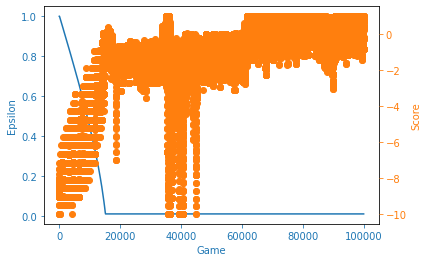

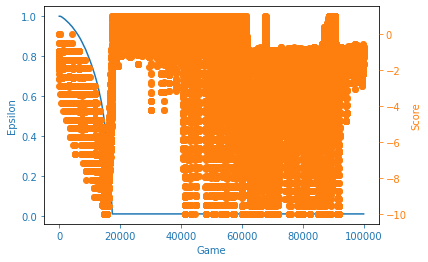

In [ ]:
# DONT RUN UNLESS YOU TRAIN
# from google.colab import drive
# drive.mount('/gdrive')

if __name__ == '__main__':
  train_phase3()
  print('First part DONE')
  train_phase2()
  print('Second part DONE')
  train_phase1()
  print('Third part DONE')
